# Initialization

In [376]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import tensorflow

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM
from keras.losses import MeanSquaredError, MeanAbsoluteError, Huber, LogCosh
from keras.optimizers import Adam

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

In [377]:
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
if tensorflow.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU.")
else:
    print("TensorFlow will run on CPU.")


Num GPUs Available:  1
TensorFlow will run on GPU.


## Function definitions

In [378]:
def prepare_data(data, n_lag=1, n_ahead=1, target_index=0, test_size=0.2):
    """
    Format time series data into input and output matrices for modeling.

    Parameters:
    - data (np.array): Time series data as a 2D Numpy array.
    - n_lag (int): Number of lagged observations as input (X).
    - n_ahead (int): Number of observations ahead to predict (Y).
    - target_index (int): Index of the target variable in the data.
    - test_size (float): Proportion of the dataset to allocate for the test set.

    Returns:
    - X_train, Y_train: Arrays of input and output for the training set.
    - X_val, Y_val: Arrays of input and output for the test set.
    """

    n_ft = data.shape[1]  # Number of features in the data

    X, Y = [], []  # Initialize input and output lists

    # Generate input-output pairs for the data
    for i in range(len(data) - n_lag - n_ahead):
        Y.append(data[(i + n_lag):(i + n_lag + n_ahead), target_index])
        X.append(data[i:(i + n_lag)])

    X, Y = np.array(X), np.array(Y)  # Convert lists to Numpy arrays

    # Reshape X for RNN input: [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], n_lag, n_ft))

    # Splitting into train and test sets
    X_train, Y_train = X[0:int(X.shape[0] * (1 - test_size))], Y[0:int(X.shape[0] * (1 - test_size))]
    X_val, Y_val = X[int(X.shape[0] * (1 - test_size)):], Y[int(X.shape[0] * (1 - test_size)):]

    return X_train, Y_train, X_val, Y_val

In [379]:
def scale_data(data, test_size):
    """
    Scales the data by normalizing it based on the training set's mean and standard deviation.

    Parameters:
    - data (pd.DataFrame): The dataset to be scaled.
    - test_size (float): The proportion of the dataset to be used as the test set.

    Returns:
    - pd.DataFrame: A concatenated DataFrame containing the scaled training and test sets.
    """
    rows = data.shape[0]

    # Split into train and test sets
    train = data[0:int(rows * (1 - test_size))]
    test = data[int(rows * (1 - test_size)):]

    # Scale the data
    train_mean = train.mean()
    train_std = train.std()

    train = (train - train_mean) / train_std
    test = (test - train_mean) / train_std

    return pd.concat([train, test]), train_mean, train_std

In [380]:
class LSTMTuner(HyperModel):
    """
    Hyperparameter tuning of LSTM models using Keras Tuner.
    
    Initialize the Tuner with configurable ranges and options for hyperparameters.
    Parameters:
    - input_shape (tuple): Shape of the input data.
    - n_outputs (int): Number of output neurons.
    - layer_range (tuple): Min and max range of LSTM layers.
    - unit_range (tuple): Range of units in each LSTM layer.
    - activation_choices (list): List of activation functions to choose from.
    - learning_rate_range (tuple): Min and max range for the learning rate.
    - loss_functions (list): List of possible loss functions.
    - batch_size_range (tuple): Range for batch size selection.
    """
    def __init__(self, input_shape, n_outputs, layer_range, unit_range, activation_choices, learning_rate_range, loss_functions, batch_size_range):
        self.input_shape            = input_shape
        self.n_outputs              = n_outputs
        self.layer_range            = layer_range
        self.unit_range             = unit_range
        self.activation_choices     = activation_choices
        self.learning_rate_range    = learning_rate_range
        self.loss_functions         = loss_functions
        self.batch_size_range       = batch_size_range


    def build(self, hp):
        """
        Build and compile an LSTM model using hyperparameters defined by Keras Tuner.

        Parameters:
        - hp: Hyperparameters object provided by Keras Tuner.

        Returns:
        - model: Compiled LSTM model with selected hyperparameters.
        """
        model = Sequential()

        # Add LSTM layers based on hyperparameters
        num_layers = hp.Int('num_layers', self.layer_range[0], self.layer_range[1])
        for i in range(num_layers):
            if i == 0:
                model.add(LSTM(
                    units = hp.Int('units_0', min_value=self.unit_range[0], max_value=self.unit_range[1], step=10),
                    activation = hp.Choice('activation_0', values=self.activation_choices),
                    input_shape = self.input_shape,
                    return_sequences = num_layers > 1
                ))
            else:
                model.add(LSTM(
                    units = hp.Int(f'units_{i}', min_value=self.unit_range[0], max_value=self.unit_range[1], step=10),
                    activation = hp.Choice(f'activation_{i}', values=self.activation_choices),
                    return_sequences = i < num_layers - 1
                ))

        model.add(Dense(self.n_outputs))# Output layer

        # Selection of the loss function based on hyperparameters
        loss_function = hp.Choice('loss_function', values=self.loss_functions)
        if loss_function == 'MAE':
            loss = MeanAbsoluteError()
        elif loss_function == 'MSE':
            loss = MeanSquaredError()
        elif loss_function == 'Huber':
            loss = Huber()
        elif loss_function == 'LogCosh':
            loss = LogCosh()
        else:
            raise ValueError("Invalid loss function")

        # Choose batch size from the hyperparameters
        batch_size = hp.Int('batch_size', min_value=self.batch_size_range[0], max_value=self.batch_size_range[1], step=8)

        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=self.learning_rate_range[0], max_value=self.learning_rate_range[1], sampling='log')),
            loss=loss
        )
        return model

In [381]:
def calculate_residuals(Y_val, forecast, train_std, train_mean, variable_name, N=7):
    """
    Function to calculate the residuals of predicting the validation set for each day ahead of prediction.
    
    Args:
    Y_val (numpy.ndarray): The actual values of the validation set.
    forecast (numpy.ndarray): The predicted values for the validation set.
    train_std (dict): The standard deviation of the training set, used for scaling.
    train_mean (dict): The mean of the training set, used for scaling.
    variable_name (str): The name of the variable for which the prediction is made.
    N (int): The number of days ahead of prediction
    
    Returns:
    pandas.DataFrame: DataFrame where each column is the residual for each day ahead of prediction.
    """
    # Initialize a list to store residuals for each day ahead
    daily_residuals = {f"{variable_name}_ahead{i+1}": [] for i in range(N)}

    # Iterate over each forecast and true value pair in the validation set
    for i in range(Y_val.shape[0]):
        true = Y_val[i]
        hat = forecast[i]

        # Scale back to original values
        true_scaled = np.asarray([(x * train_std[variable_name]) + train_mean[variable_name] for x in true])
        hat_scaled = np.asarray([(x * train_std[variable_name]) + train_mean[variable_name] for x in hat])

        # Calculate residuals for each day
        residuals = true_scaled - hat_scaled

        # Append residuals to respective lists
        for j, residual in enumerate(residuals):
            daily_residuals[f"{variable_name}_ahead{j+1}"].append(residual)

    # Convert the dictionary of lists into a DataFrame
    residuals_df = pd.DataFrame(daily_residuals)

    return residuals_df

In [382]:
def plot_error_density(residuals,feature_title,feature_name, feature_unit, n_ahead, save=False):
    if save:
        if not os.path.exists('results'):
            os.makedirs('results')
        if not os.path.exists(f'results/N={n_ahead}'):
            os.makedirs(f'results/N={n_ahead}')
        filename = f'results/N={n_ahead}/LSTM_Error Density_{feature_name}_N={n_ahead}.svg'

    plt.figure(figsize=(8, 6))
    for i, column in enumerate(residuals.columns):
        sns.kdeplot(residuals[column], label=f'Day {i+1}')
    plt.xlabel(f'{feature_title} Predictive Error ({feature_unit})')
    plt.ylabel('Density')
    plt.legend()
    if save:
        plt.savefig(filename, format='svg')
        print(f"Saved: {filename}")
    else:
        plt.show()

# Dataset preprocessing

In [383]:
# Load the CSV data into a DataFrame
hourly = pd.read_csv("Monterrey.csv")

# Format the date information
hourly['Fecha'] =  pd.to_datetime(hourly['Fecha'], format='%m/%d/%y %H:%M')

# Drop the unused weather variables
hourly = hourly.drop(columns=['DirRafaga', 'DirViento', 'RelHum', 'RapRafaga'])

# Set the timestamp column as the index
hourly.set_index('Fecha', inplace=True)

In [384]:
# Resample the data to daily frequency and calculate the average, minimum, and maximum values
daily = hourly.resample('D').agg({'Temp': ['mean', 'min', 'max'],
                                 'PresBarometr': ['mean'],
                                 'RadSolar': ['mean', 'max'],
                                 'RapViento': ['mean']})

# Flatten the column names
daily.columns = [f'{col[0]}_{col[1]}' for col in daily.columns]

# Reset the index
daily.reset_index(inplace=True)

# Drop NaNs
daily = daily.dropna()

In [385]:
data = daily.copy()

# Features used in models
features = ['Temp_mean', 'Temp_min', 'Temp_max', 'PresBarometr_mean', 'RadSolar_mean', 'RadSolar_max', 'RapViento_mean']

# Aggregating to hourly level
data = data.groupby('Fecha', as_index=False)[features].mean()

# Print dataset information
print(f"First date {min(data['Fecha'])}")
print(f"Most recent date {max(data['Fecha'])}")
print(f"Total unique dates in the dataset: {len(set(data['Fecha']))}")
print(f"Number of rows in the dataset: {data.shape[0]}")

First date 2005-05-09 00:00:00
Most recent date 2023-03-03 00:00:00
Total unique dates in the dataset: 4411
Number of rows in the dataset: 4411


In [386]:
# Removing non-features
data = data[features]

# Print features
print("Features in the dataset:")
for column in data.columns:
    print(f" - {column}")

Features in the dataset:
 - Temp_mean
 - Temp_min
 - Temp_max
 - PresBarometr_mean
 - RadSolar_mean
 - RadSolar_max
 - RapViento_mean


In [387]:
# Titles for the features
feature_title = ["Average Temperature",
                 "Minimum Temperature",
                 "Maximum Temperature",
                 "Average Pressure", 
                 "Average Solar Radiation", 
                 "Maximum Solar Radiation",
                 "Average Wind Speed"]

# Units for the features
feature_unit = ["°C",
                "°C",
                "°C",
                "hPa",
                "W/m^2",
                "W/m^2",
                "m/s"]

# Hypermodel definition

In [388]:
# Basic settings
n_lag     = 60 # Number of lags (days back) to use for prediction
n_ahead   = 60 # Number of steps (days) ahead to forecast
n_ft      = data.shape[1] # Number of features (weather variables)
epochs    = 20 # Number of epochs for training
test_size = 0.2 # Define portion to use for the test set

# Hypermodel settings
max_trials           = 100 # Number of trials the Hypermodel will run
executions_per_trial = 2 # Number of executions of the model per trial
directory            = 'keras-tuner' # Directory name where results will be saved

# Hyperparameter ranges
layer_range         = (1, 6) # Range of LSTM layers
unit_range          = (10, 300) # Range of units in each LSTM layer
activation_choices  = ['relu', 'tanh', 'sigmoid', 'softmax'] # Range of activation functions
learning_rate_range = (1e-4, 1e-1)  # Range for the learning rate
loss_functions      = ['MAE'] # List of activation functions to choose from
batch_size_range    = (32, 128) # Range for batch size selection

In [389]:
# Initialize the hypermodel with batch size range
hypermodel = LSTMTuner(
    input_shape         = [n_lag, n_ft],
    n_outputs           = n_ahead,
    layer_range         = layer_range,
    unit_range          = unit_range,
    activation_choices  = activation_choices,
    learning_rate_range = learning_rate_range,
    loss_functions      = loss_functions,
    batch_size_range    = batch_size_range
)

In [390]:
# Scale and normalize the dataset
data_scaled, train_mean, train_std = scale_data(data, test_size)

# Predictive models

## Average Temperature

In [391]:
target_index = 0 # Select proper target index as the weather variable to predict in the features array

In [392]:
# Prepare the dataset for the model
X_train, Y_train, X_val, Y_val = prepare_data(
    data_scaled.values,
    n_lag        = n_lag,
    n_ahead      = n_ahead,
    target_index = target_index, # Select proper target index as the weather variable to predict
    test_size    = test_size
)

In [393]:
# Initialize the tuner
Temp_mean_tuner = RandomSearch(
    hypermodel,
    objective               = 'val_loss',
    max_trials              = max_trials,
    executions_per_trial    = executions_per_trial,
    directory               = directory,
    project_name            = features[target_index]
)

Reloading Tuner from keras-tuner\Temp_mean\tuner0.json


In [394]:
# Search best parameters
Temp_mean_tuner.search(
    x               = X_train,
    y               = Y_train,
    epochs          = epochs,
    validation_data = (X_val, Y_val)
)

In [395]:
best_hyperparameters = Temp_mean_tuner.get_best_hyperparameters(num_trials=1)[0]
best_loss_function = best_hyperparameters.get('loss_function')
for param in best_hyperparameters.values:
    print(f"{param}: {best_hyperparameters.get(param)}")

num_layers: 1
units_0: 40
activation_0: sigmoid
loss_function: MAE
batch_size: 64
learning_rate: 0.010095606097625293
units_1: 200
activation_1: sigmoid
units_2: 250
activation_2: tanh
units_3: 250
activation_3: softmax
units_4: 70
activation_4: softmax
units_5: 210
activation_5: tanh


In [396]:
Temp_mean_model = hypermodel.build(best_hyperparameters)
Temp_mean_model.compile(optimizer='adam', loss=best_loss_function, metrics=['mae'])
Temp_mean_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 40)                7680      
                                                                 
 dense_35 (Dense)            (None, 60)                2460      
                                                                 
Total params: 10,140
Trainable params: 10,140
Non-trainable params: 0
_________________________________________________________________


In [397]:
Temp_mean_history = Temp_mean_model.fit(X_train, Y_train, epochs=epochs, batch_size=best_hyperparameters.get('batch_size'), validation_data=(X_val, Y_val))
Temp_mean_forecast = Temp_mean_model.predict(X_val)
Temp_mean_error = calculate_residuals(Y_val, Temp_mean_forecast, train_std, train_mean, features[target_index], N=n_ahead)

Epoch 1/20
54/54 [==============================] - 5s 79ms/step - loss: 0.7746 - mae: 0.7746 - val_loss: 0.7568 - val_mae: 0.7568
Epoch 2/20
54/54 [==============================] - 4s 81ms/step - loss: 0.6384 - mae: 0.6384 - val_loss: 0.6115 - val_mae: 0.6115
Epoch 3/20
54/54 [==============================] - 4s 72ms/step - loss: 0.5775 - mae: 0.5775 - val_loss: 0.5991 - val_mae: 0.5991
Epoch 4/20
54/54 [==============================] - 4s 70ms/step - loss: 0.5642 - mae: 0.5642 - val_loss: 0.5942 - val_mae: 0.5942
Epoch 5/20
54/54 [==============================] - 4s 66ms/step - loss: 0.5530 - mae: 0.5530 - val_loss: 0.5864 - val_mae: 0.5864
Epoch 6/20
54/54 [==============================] - 4s 67ms/step - loss: 0.5411 - mae: 0.5411 - val_loss: 0.5788 - val_mae: 0.5788
Epoch 7/20
54/54 [==============================] - 4s 67ms/step - loss: 0.5271 - mae: 0.5271 - val_loss: 0.5689 - val_mae: 0.5689
Epoch 8/20
54/54 [==============================] - 4s 65ms/step - loss: 0.5085 - m

Saved: results/N=60/LSTM_Error Density_Temp_mean_N=60.svg


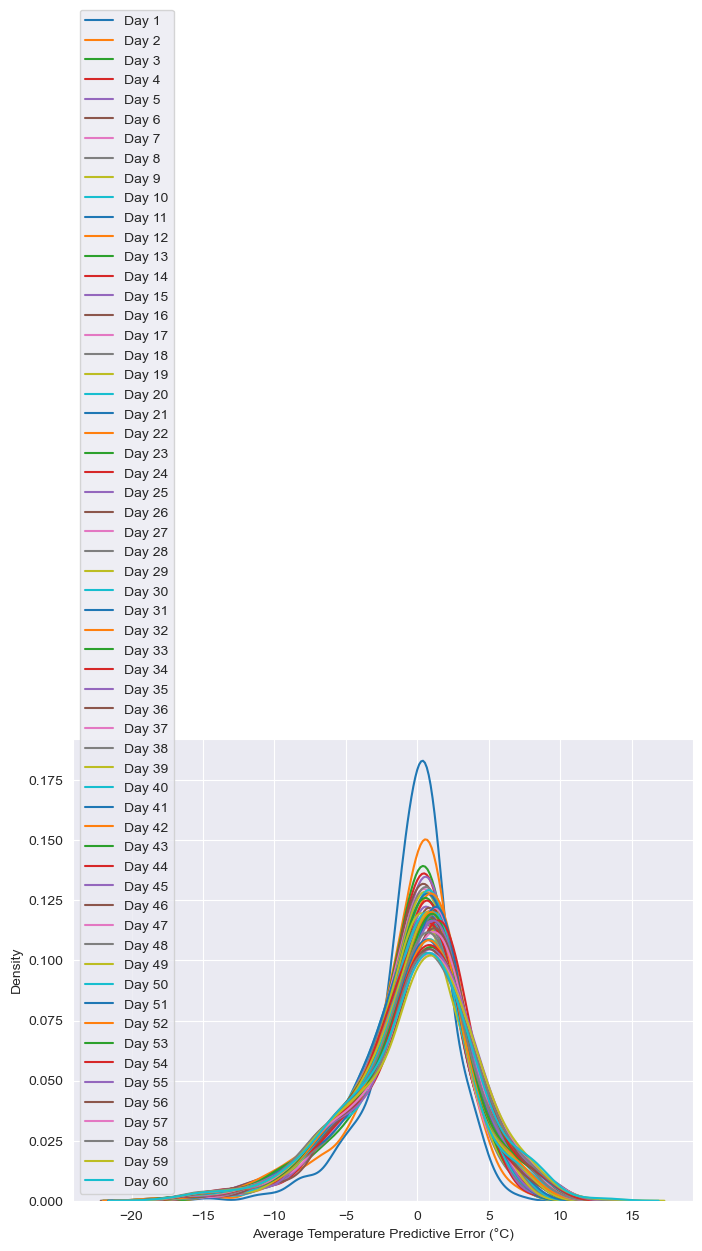

In [398]:
# Plot error density per day ahead of prediction
plot_error_density(Temp_mean_error,feature_title[target_index],features[target_index],feature_unit[target_index],n_ahead,save=True) # save = True to save .svg

## Minimum Temperature

In [399]:
target_index = 1 # Select proper target index as the weather variable to predict in the features array

In [400]:
# Prepare the dataset for the model
X_train, Y_train, X_val, Y_val = prepare_data(
    data_scaled.values,
    n_lag        = n_lag,
    n_ahead      = n_ahead,
    target_index = target_index,
    test_size    = test_size
)

In [401]:
# Initialize the tuner
Temp_min_tuner = RandomSearch(
    hypermodel,
    objective               = 'val_loss',
    max_trials              = max_trials,
    executions_per_trial    = executions_per_trial,
    directory               = directory,
    project_name            = features[target_index]
)

Reloading Tuner from keras-tuner\Temp_min\tuner0.json


In [402]:
# Search best parameters
Temp_min_tuner.search(
    x               = X_train,
    y               = Y_train,
    epochs          = epochs,
    validation_data = (X_val, Y_val)
)

In [403]:
best_hyperparameters = Temp_min_tuner.get_best_hyperparameters(num_trials=1)[0]
best_loss_function = best_hyperparameters.get('loss_function')
for param in best_hyperparameters.values:
    print(f"{param}: {best_hyperparameters.get(param)}")

num_layers: 1
units_0: 250
activation_0: relu
loss_function: MAE
batch_size: 128
learning_rate: 0.0017271315864766778
units_1: 90
activation_1: tanh
units_2: 180
activation_2: sigmoid
units_3: 280
activation_3: relu
units_4: 50
activation_4: softmax
units_5: 300
activation_5: tanh


In [404]:
Temp_min_model = hypermodel.build(best_hyperparameters)
Temp_min_model.compile(optimizer='adam', loss=best_loss_function, metrics=['mae'])
Temp_min_model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 250)               258000    
                                                                 
 dense_36 (Dense)            (None, 60)                15060     
                                                                 
Total params: 273,060
Trainable params: 273,060
Non-trainable params: 0
_________________________________________________________________


In [405]:
Temp_min_history = Temp_min_model.fit(X_train, Y_train, epochs=epochs, batch_size=best_hyperparameters.get('batch_size'), validation_data=(X_val, Y_val))
Temp_min_forecast = Temp_min_model.predict(X_val)
Temp_min_error = calculate_residuals(Y_val, Temp_min_forecast, train_std, train_mean, features[target_index], N=n_ahead)

Epoch 1/20
27/27 [==============================] - 2s 70ms/step - loss: 0.7110 - mae: 0.7110 - val_loss: 0.6494 - val_mae: 0.6494
Epoch 2/20
27/27 [==============================] - 2s 65ms/step - loss: 0.5664 - mae: 0.5664 - val_loss: 0.5404 - val_mae: 0.5404
Epoch 3/20
27/27 [==============================] - 2s 65ms/step - loss: 0.5358 - mae: 0.5358 - val_loss: 0.5540 - val_mae: 0.5540
Epoch 4/20
27/27 [==============================] - 2s 64ms/step - loss: 0.5229 - mae: 0.5229 - val_loss: 0.5362 - val_mae: 0.5362
Epoch 5/20
27/27 [==============================] - 2s 64ms/step - loss: 0.5004 - mae: 0.5004 - val_loss: 0.5149 - val_mae: 0.5149
Epoch 6/20
27/27 [==============================] - 2s 64ms/step - loss: 0.4687 - mae: 0.4687 - val_loss: 0.5047 - val_mae: 0.5047
Epoch 7/20
27/27 [==============================] - 2s 65ms/step - loss: 0.4454 - mae: 0.4454 - val_loss: 0.4792 - val_mae: 0.4792
Epoch 8/20
27/27 [==============================] - 2s 66ms/step - loss: 0.4307 - m

Saved: results/N=60/LSTM_Error Density_Temp_min_N=60.svg


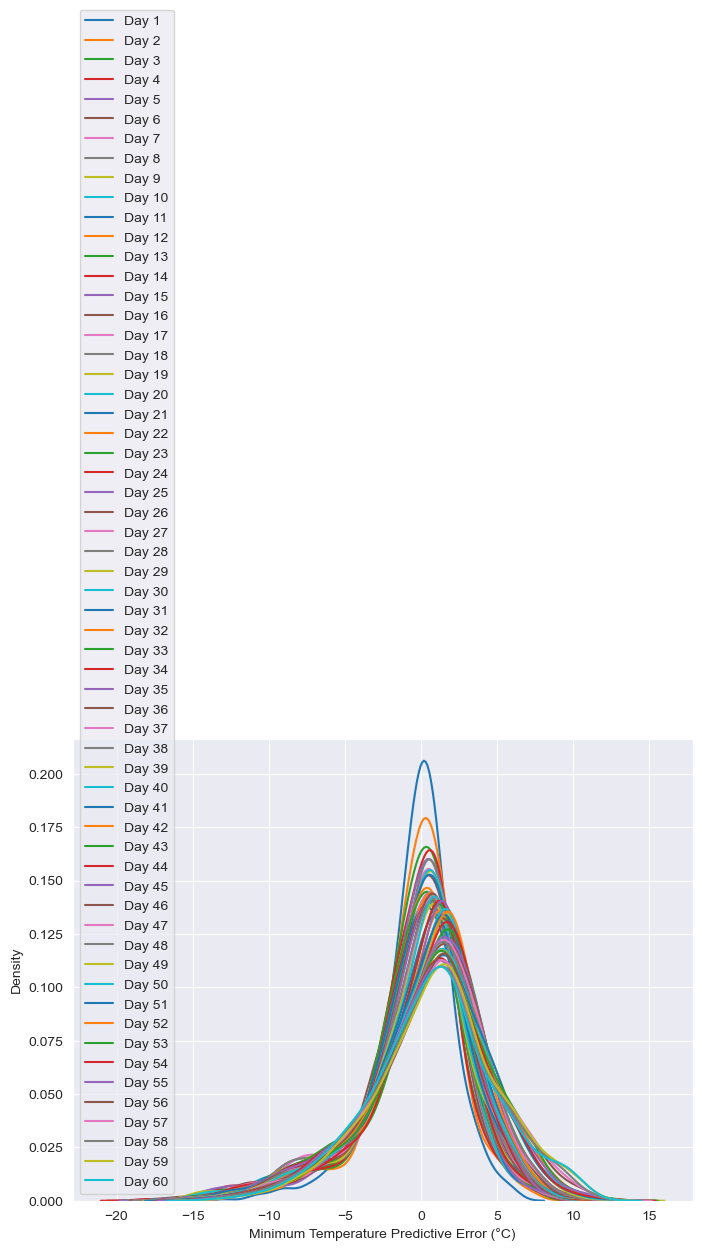

In [406]:
# Plot error density per day ahead of prediction
plot_error_density(Temp_min_error,feature_title[target_index],features[target_index],feature_unit[target_index],n_ahead,save=True) # save = True to save .svg

## Maximum Temperature

In [407]:
target_index = 2 # Select proper target index as the weather variable to predict in the features array

In [408]:
# Prepare the dataset for the model
X_train, Y_train, X_val, Y_val = prepare_data(
    data_scaled.values,
    n_lag        = n_lag,
    n_ahead      = n_ahead,
    target_index = target_index,
    test_size    = test_size
)

In [409]:
# Initialize the tuner
Temp_max_tuner = RandomSearch(
    hypermodel,
    objective               = 'val_loss',
    max_trials              = max_trials,
    executions_per_trial    = executions_per_trial,
    directory               = directory,
    project_name            = features[target_index]
)

Reloading Tuner from keras-tuner\Temp_max\tuner0.json


In [410]:
# Search best parameters
Temp_max_tuner.search(
    x               = X_train,
    y               = Y_train,
    epochs          = epochs,
    validation_data = (X_val, Y_val)
)

In [411]:
best_hyperparameters = Temp_max_tuner.get_best_hyperparameters(num_trials=1)[0]
best_loss_function = best_hyperparameters.get('loss_function')
for param in best_hyperparameters.values:
    print(f"{param}: {best_hyperparameters.get(param)}")

num_layers: 1
units_0: 40
activation_0: tanh
loss_function: MAE
batch_size: 96
learning_rate: 0.0030476495908406736
units_1: 190
activation_1: relu
units_2: 300
activation_2: sigmoid
units_3: 30
activation_3: tanh
units_4: 70
activation_4: softmax
units_5: 220
activation_5: tanh


In [412]:
Temp_max_model = hypermodel.build(best_hyperparameters)
Temp_max_model.compile(optimizer='adam', loss=best_loss_function, metrics=['mae'])
Temp_max_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 40)                7680      
                                                                 
 dense_37 (Dense)            (None, 60)                2460      
                                                                 
Total params: 10,140
Trainable params: 10,140
Non-trainable params: 0
_________________________________________________________________


In [413]:
Temp_max_history = Temp_max_model.fit(X_train, Y_train, epochs=epochs, batch_size=best_hyperparameters.get('batch_size'), validation_data=(X_val, Y_val))
Temp_max_forecast = Temp_max_model.predict(X_val)
Temp_max_error = calculate_residuals(Y_val, Temp_max_forecast, train_std, train_mean, features[target_index], N=n_ahead)

Epoch 1/20
36/36 [==============================] - 1s 17ms/step - loss: 0.7260 - mae: 0.7260 - val_loss: 0.6810 - val_mae: 0.6810
Epoch 2/20
36/36 [==============================] - 0s 8ms/step - loss: 0.5995 - mae: 0.5995 - val_loss: 0.6316 - val_mae: 0.6316
Epoch 3/20
36/36 [==============================] - 0s 6ms/step - loss: 0.5593 - mae: 0.5593 - val_loss: 0.6100 - val_mae: 0.6100
Epoch 4/20
36/36 [==============================] - 0s 6ms/step - loss: 0.5409 - mae: 0.5409 - val_loss: 0.6258 - val_mae: 0.6258
Epoch 5/20
36/36 [==============================] - 0s 6ms/step - loss: 0.5313 - mae: 0.5313 - val_loss: 0.6059 - val_mae: 0.6059
Epoch 6/20
36/36 [==============================] - 0s 6ms/step - loss: 0.5264 - mae: 0.5264 - val_loss: 0.6035 - val_mae: 0.6035
Epoch 7/20
36/36 [==============================] - 0s 6ms/step - loss: 0.5208 - mae: 0.5208 - val_loss: 0.6177 - val_mae: 0.6177
Epoch 8/20
36/36 [==============================] - 0s 6ms/step - loss: 0.5169 - mae: 0.5

Saved: results/N=60/LSTM_Error Density_Temp_max_N=60.svg


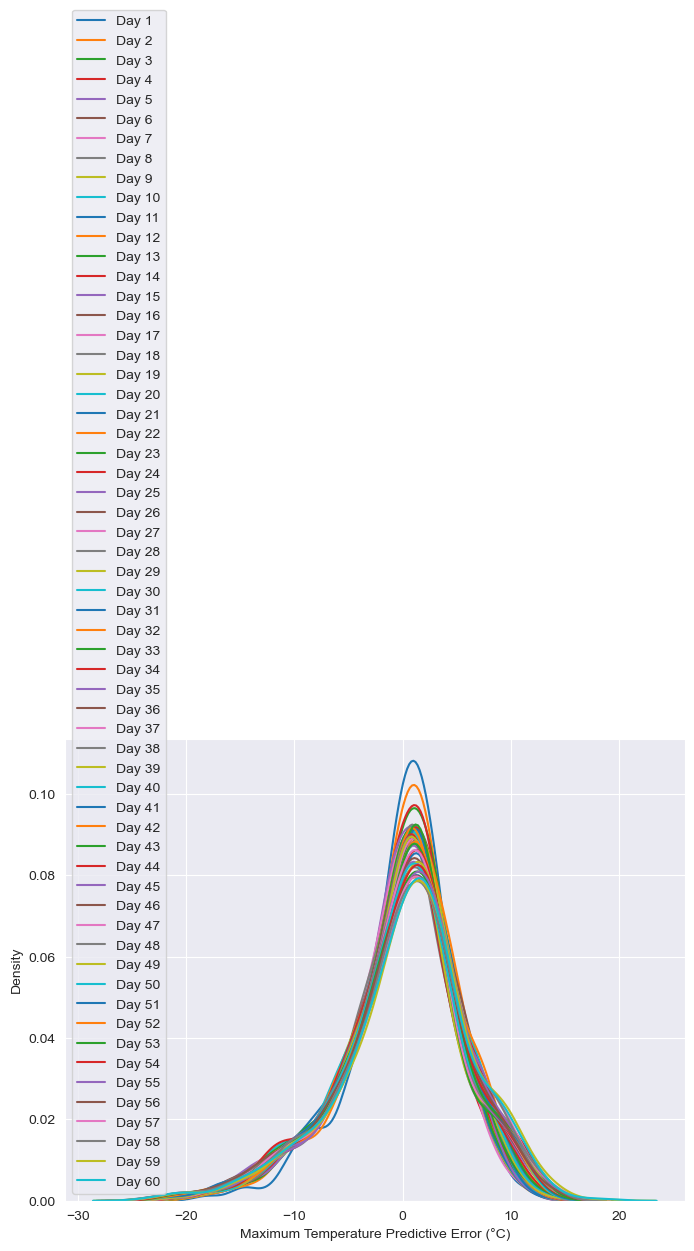

In [414]:
# Plot error density per day ahead of prediction
plot_error_density(Temp_max_error,feature_title[target_index],features[target_index],feature_unit[target_index],n_ahead,save=True) # save = True to save .svg

## Average Pressure

In [415]:
target_index = 3 # Select proper target index as the weather variable to predict

In [416]:
# Prepare the dataset for the model
X_train, Y_train, X_val, Y_val = prepare_data(
    data_scaled.values,
    n_lag        = n_lag,
    n_ahead      = n_ahead,
    target_index = target_index, 
    test_size    = test_size
)

In [417]:
# Initialize the tuner
PresBarometr_mean_tuner = RandomSearch(
    hypermodel,
    objective               = 'val_loss',
    max_trials              = max_trials,
    executions_per_trial    = executions_per_trial,
    directory               = directory,
    project_name            = features[target_index]
)

Reloading Tuner from keras-tuner\PresBarometr_mean\tuner0.json


In [418]:
# Search best parameters
PresBarometr_mean_tuner.search(
    x               = X_train,
    y               = Y_train,
    epochs          = epochs,
    validation_data = (X_val, Y_val)
)

In [419]:
best_hyperparameters = PresBarometr_mean_tuner.get_best_hyperparameters(num_trials=1)[0]
best_loss_function = best_hyperparameters.get('loss_function')
for param in best_hyperparameters.values:
    print(f"{param}: {best_hyperparameters.get(param)}")

num_layers: 4
units_0: 160
activation_0: relu
loss_function: MAE
batch_size: 112
learning_rate: 0.0013327006612151699
units_1: 250
activation_1: relu
units_2: 20
activation_2: relu
units_3: 90
activation_3: sigmoid
units_4: 180
activation_4: relu
units_5: 20
activation_5: sigmoid


In [420]:
PresBarometr_mean_model = hypermodel.build(best_hyperparameters)
PresBarometr_mean_model.compile(optimizer='adam', loss=best_loss_function, metrics=['mae'])
PresBarometr_mean_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 60, 160)           107520    
                                                                 
 lstm_79 (LSTM)              (None, 60, 250)           411000    
                                                                 
 lstm_80 (LSTM)              (None, 60, 20)            21680     
                                                                 
 lstm_81 (LSTM)              (None, 90)                39960     
                                                                 
 dense_38 (Dense)            (None, 60)                5460      
                                                                 
Total params: 585,620
Trainable params: 585,620
Non-trainable params: 0
_________________________________________________________________


In [421]:
PresBarometr_mean_history = PresBarometr_mean_model.fit(X_train, Y_train, epochs=epochs, batch_size=best_hyperparameters.get('batch_size'), validation_data=(X_val, Y_val))
PresBarometr_mean_forecast = PresBarometr_mean_model.predict(X_val)
PresBarometr_mean_error = calculate_residuals(Y_val, PresBarometr_mean_forecast, train_std, train_mean, features[target_index], N=n_ahead)

Epoch 1/20
31/31 [==============================] - 11s 288ms/step - loss: 0.7756 - mae: 0.7756 - val_loss: 0.7625 - val_mae: 0.7625
Epoch 2/20
31/31 [==============================] - 9s 276ms/step - loss: 0.7383 - mae: 0.7383 - val_loss: 0.7384 - val_mae: 0.7384
Epoch 3/20
31/31 [==============================] - 8s 272ms/step - loss: 0.6933 - mae: 0.6933 - val_loss: 0.7508 - val_mae: 0.7508
Epoch 4/20
31/31 [==============================] - 8s 274ms/step - loss: 0.6719 - mae: 0.6719 - val_loss: 0.7330 - val_mae: 0.7330
Epoch 5/20
31/31 [==============================] - 8s 268ms/step - loss: 0.6601 - mae: 0.6601 - val_loss: 0.7172 - val_mae: 0.7172
Epoch 6/20
31/31 [==============================] - 8s 271ms/step - loss: 0.6495 - mae: 0.6495 - val_loss: 0.7495 - val_mae: 0.7495
Epoch 7/20
31/31 [==============================] - 8s 271ms/step - loss: 0.6430 - mae: 0.6430 - val_loss: 0.7096 - val_mae: 0.7096
Epoch 8/20
31/31 [==============================] - 9s 278ms/step - loss: 0

Saved: results/N=60/LSTM_Error Density_PresBarometr_mean_N=60.svg


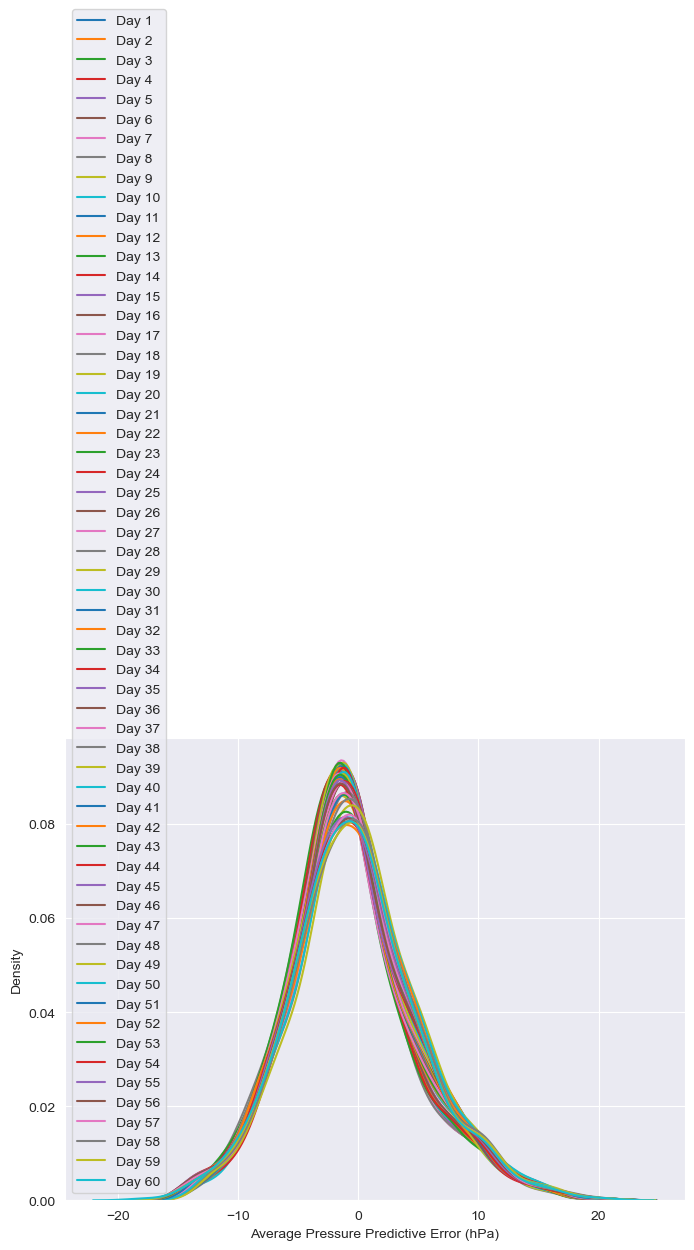

In [422]:
# Plot error density per day ahead of prediction
plot_error_density(PresBarometr_mean_error,feature_title[target_index],features[target_index],feature_unit[target_index],n_ahead,save=True) # save = True to save .svg

## Average Solar Radiation

In [423]:
target_index = 4 # Select proper target index as the weather variable to predict

In [424]:
# Prepare the dataset for the model
X_train, Y_train, X_val, Y_val = prepare_data(
    data_scaled.values,
    n_lag        = n_lag,
    n_ahead      = n_ahead,
    target_index = target_index, 
    test_size    = test_size
)

In [425]:
# Initialize the tuner
RadSolar_mean_tuner = RandomSearch(
    hypermodel,
    objective               = 'val_loss',
    max_trials              = max_trials,
    executions_per_trial    = executions_per_trial,
    directory               = directory,
    project_name            = features[target_index]
)

Reloading Tuner from keras-tuner\RadSolar_mean\tuner0.json


In [426]:
# Search best parameters
RadSolar_mean_tuner.search(
    x               = X_train,
    y               = Y_train,
    epochs          = epochs,
    validation_data = (X_val, Y_val)
)

In [427]:
best_hyperparameters = RadSolar_mean_tuner.get_best_hyperparameters(num_trials=1)[0]
best_loss_function = best_hyperparameters.get('loss_function')
for param in best_hyperparameters.values:
    print(f"{param}: {best_hyperparameters.get(param)}")

num_layers: 2
units_0: 230
activation_0: sigmoid
loss_function: MAE
batch_size: 32
learning_rate: 0.0017545326289340611
units_1: 160
activation_1: relu
units_2: 40
activation_2: tanh
units_3: 90
activation_3: tanh
units_4: 30
activation_4: tanh
units_5: 230
activation_5: softmax


In [428]:
RadSolar_mean_model = hypermodel.build(best_hyperparameters)
RadSolar_mean_model.compile(optimizer='adam', loss=best_loss_function, metrics=['mae'])
RadSolar_mean_model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 60, 230)           218960    
                                                                 
 lstm_83 (LSTM)              (None, 160)               250240    
                                                                 
 dense_39 (Dense)            (None, 60)                9660      
                                                                 
Total params: 478,860
Trainable params: 478,860
Non-trainable params: 0
_________________________________________________________________


In [429]:
RadSolar_mean_history = RadSolar_mean_model.fit(X_train, Y_train, epochs=epochs, batch_size=best_hyperparameters.get('batch_size'), validation_data=(X_val, Y_val))
RadSolar_mean_forecast = PresBarometr_mean_model.predict(X_val)
RadSolar_mean_error = calculate_residuals(Y_val, PresBarometr_mean_forecast, train_std, train_mean, features[target_index], N=n_ahead)

Epoch 1/20
108/108 [==============================] - 17s 142ms/step - loss: 0.7126 - mae: 0.7126 - val_loss: 0.4681 - val_mae: 0.4681
Epoch 2/20
108/108 [==============================] - 15s 137ms/step - loss: 0.6463 - mae: 0.6463 - val_loss: 0.4612 - val_mae: 0.4612
Epoch 3/20
108/108 [==============================] - 15s 140ms/step - loss: 0.5803 - mae: 0.5803 - val_loss: 0.4492 - val_mae: 0.4492
Epoch 4/20
108/108 [==============================] - 15s 140ms/step - loss: 0.5671 - mae: 0.5671 - val_loss: 0.4424 - val_mae: 0.4424
Epoch 5/20
108/108 [==============================] - 15s 140ms/step - loss: 0.5566 - mae: 0.5566 - val_loss: 0.4362 - val_mae: 0.4362
Epoch 6/20
108/108 [==============================] - 15s 136ms/step - loss: 0.5506 - mae: 0.5506 - val_loss: 0.4301 - val_mae: 0.4301
Epoch 7/20
108/108 [==============================] - 15s 138ms/step - loss: 0.5416 - mae: 0.5416 - val_loss: 0.4218 - val_mae: 0.4218
Epoch 8/20
108/108 [==============================] - 1

Saved: results/N=60/LSTM_Error Density_RadSolar_mean_N=60.svg


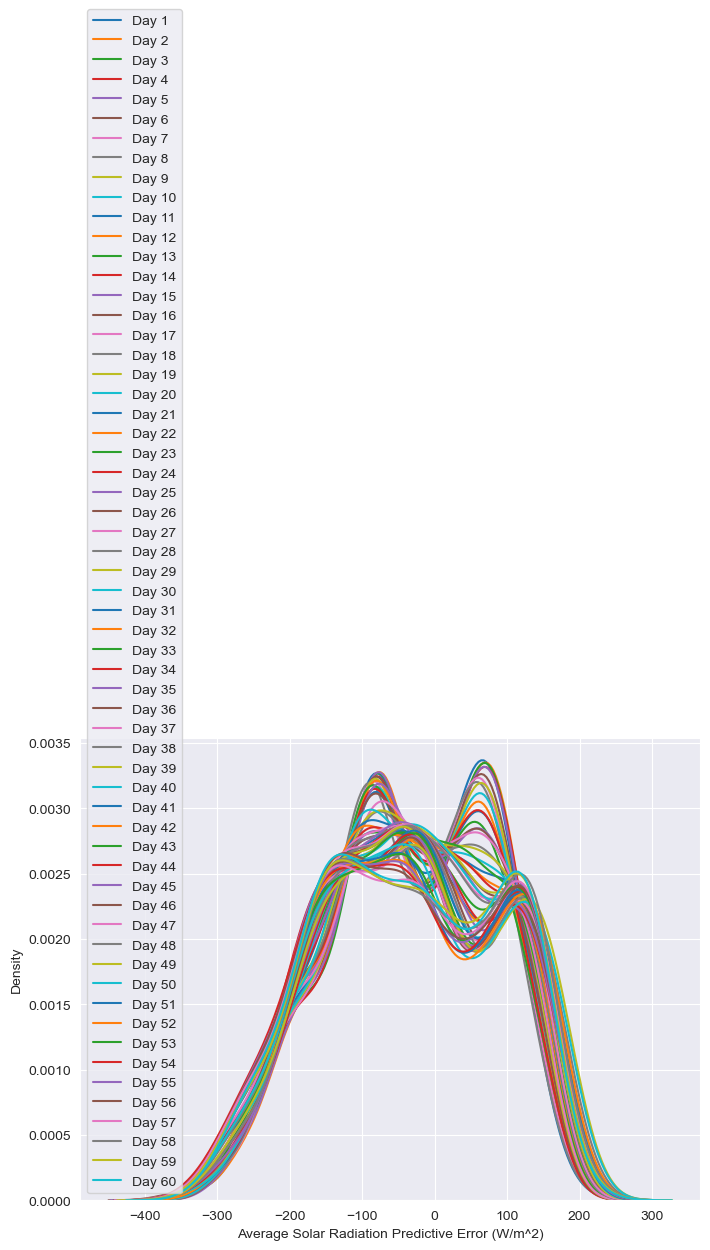

In [430]:
# Plot error density per day ahead of prediction
plot_error_density(RadSolar_mean_error,feature_title[target_index],features[target_index],feature_unit[target_index],n_ahead,save=True) # save = True to save .svg

## Maximum Solar Radiation

In [431]:
target_index = 5 # Select proper target index as the weather variable to predict

In [432]:
# Prepare the dataset for the model
X_train, Y_train, X_val, Y_val = prepare_data(
    data_scaled.values,
    n_lag        = n_lag,
    n_ahead      = n_ahead,
    target_index = target_index, 
    test_size    = test_size
)

In [433]:
# Initialize the tuner
RadSolar_max_tuner = RandomSearch(
    hypermodel,
    objective               = 'val_loss',
    max_trials              = max_trials,
    executions_per_trial    = executions_per_trial,
    directory               = directory,
    project_name            = features[target_index]
)

Reloading Tuner from keras-tuner\RadSolar_max\tuner0.json


In [434]:
# Search best parameters
RadSolar_max_tuner.search(
    x               = X_train,
    y               = Y_train,
    epochs          = epochs,
    validation_data = (X_val, Y_val)
)

In [435]:
best_hyperparameters = RadSolar_max_tuner.get_best_hyperparameters(num_trials=1)[0]
best_loss_function = best_hyperparameters.get('loss_function')
for param in best_hyperparameters.values:
    print(f"{param}: {best_hyperparameters.get(param)}")

num_layers: 4
units_0: 60
activation_0: tanh
loss_function: MAE
batch_size: 48
learning_rate: 0.0015830861640198095
units_1: 170
activation_1: tanh
units_2: 240
activation_2: sigmoid
units_3: 200
activation_3: relu
units_4: 130
activation_4: tanh
units_5: 50
activation_5: softmax


In [436]:
RadSolar_max_model = hypermodel.build(best_hyperparameters)
RadSolar_max_model.compile(optimizer='adam', loss=best_loss_function, metrics=['mae'])
RadSolar_max_model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 60, 60)            16320     
                                                                 
 lstm_85 (LSTM)              (None, 60, 170)           157080    
                                                                 
 lstm_86 (LSTM)              (None, 60, 240)           394560    
                                                                 
 lstm_87 (LSTM)              (None, 200)               352800    
                                                                 
 dense_40 (Dense)            (None, 60)                12060     
                                                                 
Total params: 932,820
Trainable params: 932,820
Non-trainable params: 0
_________________________________________________________________


In [437]:
RadSolar_max_history = RadSolar_max_model.fit(X_train, Y_train, epochs=epochs, batch_size=best_hyperparameters.get('batch_size'), validation_data=(X_val, Y_val))
RadSolar_max_forecast = RadSolar_max_model.predict(X_val)
RadSolar_max_error = calculate_residuals(Y_val, RadSolar_max_forecast, train_std, train_mean, features[target_index], N=n_ahead)

Epoch 1/20
72/72 [==============================] - 14s 158ms/step - loss: 0.6051 - mae: 0.6051 - val_loss: 0.5241 - val_mae: 0.5241
Epoch 2/20
72/72 [==============================] - 12s 166ms/step - loss: 0.5120 - mae: 0.5120 - val_loss: 0.5144 - val_mae: 0.5144
Epoch 3/20
72/72 [==============================] - 11s 152ms/step - loss: 0.4809 - mae: 0.4809 - val_loss: 0.5057 - val_mae: 0.5057
Epoch 4/20
72/72 [==============================] - 11s 153ms/step - loss: 0.4652 - mae: 0.4652 - val_loss: 0.5070 - val_mae: 0.5070
Epoch 5/20
72/72 [==============================] - 11s 155ms/step - loss: 0.4582 - mae: 0.4582 - val_loss: 0.4883 - val_mae: 0.4883
Epoch 6/20
72/72 [==============================] - 11s 152ms/step - loss: 0.4518 - mae: 0.4518 - val_loss: 0.4788 - val_mae: 0.4788
Epoch 7/20
72/72 [==============================] - 11s 151ms/step - loss: 0.4504 - mae: 0.4504 - val_loss: 0.4991 - val_mae: 0.4991
Epoch 8/20
72/72 [==============================] - 11s 151ms/step - 

Saved: results/N=60/LSTM_Error Density_RadSolar_max_N=60.svg


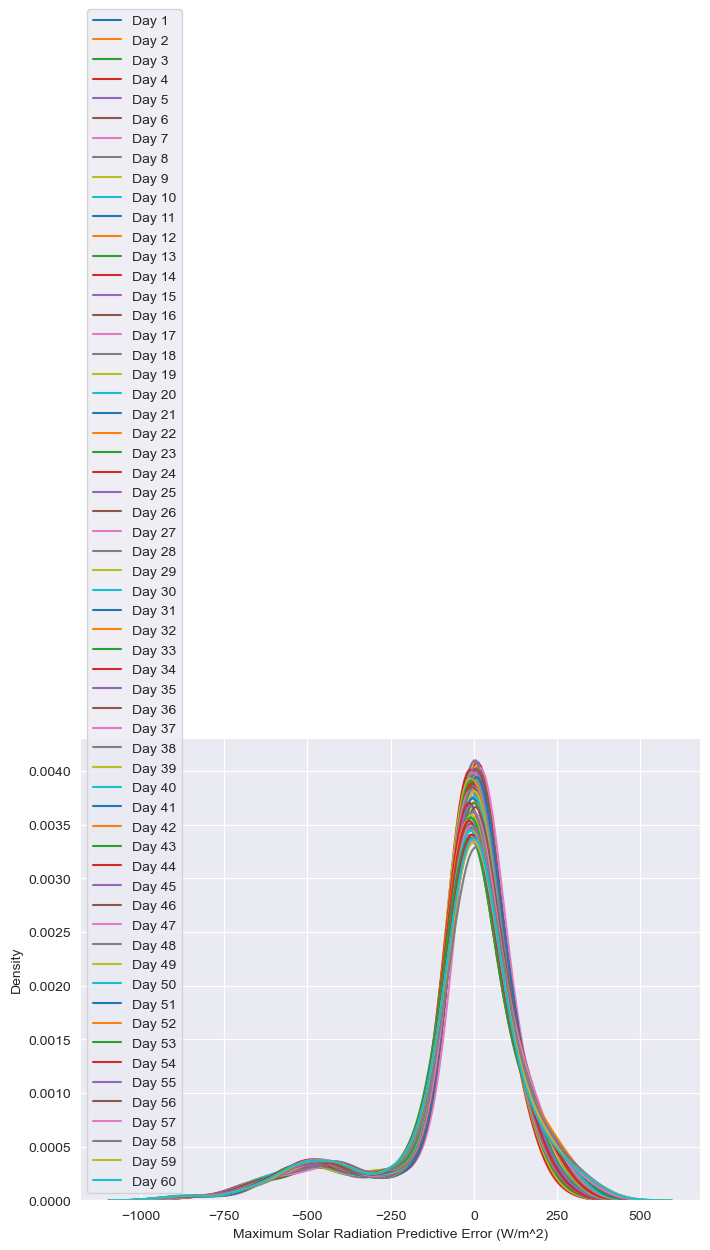

In [438]:
# Plot error density per day ahead of prediction
plot_error_density(RadSolar_max_error,feature_title[target_index],features[target_index],feature_unit[target_index],n_ahead,save=True) # save = True to save .svg

## Average Wind Speed

In [439]:
target_index = 6 # Select proper target index as the weather variable to predict

In [440]:
# Prepare the dataset for the model
X_train, Y_train, X_val, Y_val = prepare_data(
    data_scaled.values,
    n_lag        = n_lag,
    n_ahead      = n_ahead,
    target_index = target_index, 
    test_size    = test_size
)

In [441]:
# Initialize the tuner
RapViento_mean_tuner = RandomSearch(
    hypermodel,
    objective               = 'val_loss',
    max_trials              = max_trials,
    executions_per_trial    = executions_per_trial,
    directory               = directory,
    project_name            = features[target_index]
)

Reloading Tuner from keras-tuner\RapViento_mean\tuner0.json


In [442]:
# Search best parameters
RapViento_mean_tuner.search(
    x               = X_train,
    y               = Y_train,
    epochs          = epochs,
    validation_data = (X_val, Y_val)
)

In [443]:
best_hyperparameters = RapViento_mean_tuner.get_best_hyperparameters(num_trials=1)[0]
best_loss_function = best_hyperparameters.get('loss_function')
for param in best_hyperparameters.values:
    print(f"{param}: {best_hyperparameters.get(param)}")

num_layers: 2
units_0: 230
activation_0: relu
loss_function: MAE
batch_size: 104
learning_rate: 0.0008848688594274479
units_1: 280
activation_1: tanh
units_2: 20
activation_2: relu
units_3: 260
activation_3: tanh
units_4: 140
activation_4: sigmoid
units_5: 220
activation_5: tanh


In [444]:
RapViento_mean_model = hypermodel.build(best_hyperparameters)
RapViento_mean_model.compile(optimizer='adam', loss=best_loss_function, metrics=['mae'])
RapViento_mean_model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 60, 230)           218960    
                                                                 
 lstm_89 (LSTM)              (None, 280)               572320    
                                                                 
 dense_41 (Dense)            (None, 60)                16860     
                                                                 
Total params: 808,140
Trainable params: 808,140
Non-trainable params: 0
_________________________________________________________________


In [445]:
RapViento_mean_history = RapViento_mean_model.fit(X_train, Y_train, epochs=epochs, batch_size=best_hyperparameters.get('batch_size'), validation_data=(X_val, Y_val))
RapViento_mean_forecast = RapViento_mean_model.predict(X_val)
RapViento_mean_error = calculate_residuals(Y_val, RapViento_mean_forecast, train_std, train_mean, features[target_index], N=n_ahead)

Epoch 1/20
33/33 [==============================] - 3s 51ms/step - loss: 0.6629 - mae: 0.6629 - val_loss: 0.6520 - val_mae: 0.6520
Epoch 2/20
33/33 [==============================] - 1s 39ms/step - loss: 0.6005 - mae: 0.6005 - val_loss: 0.6466 - val_mae: 0.6466
Epoch 3/20
33/33 [==============================] - 1s 39ms/step - loss: 0.5899 - mae: 0.5899 - val_loss: 0.6481 - val_mae: 0.6481
Epoch 4/20
33/33 [==============================] - 1s 38ms/step - loss: 0.5839 - mae: 0.5839 - val_loss: 0.6330 - val_mae: 0.6330
Epoch 5/20
33/33 [==============================] - 1s 38ms/step - loss: 0.5798 - mae: 0.5798 - val_loss: 0.6479 - val_mae: 0.6479
Epoch 6/20
33/33 [==============================] - 1s 38ms/step - loss: 0.5756 - mae: 0.5756 - val_loss: 0.6629 - val_mae: 0.6629
Epoch 7/20
33/33 [==============================] - 1s 38ms/step - loss: 0.5700 - mae: 0.5700 - val_loss: 0.6500 - val_mae: 0.6500
Epoch 8/20
33/33 [==============================] - 1s 38ms/step - loss: 0.5669 - m

Saved: results/N=60/LSTM_Error Density_RapViento_mean_N=60.svg


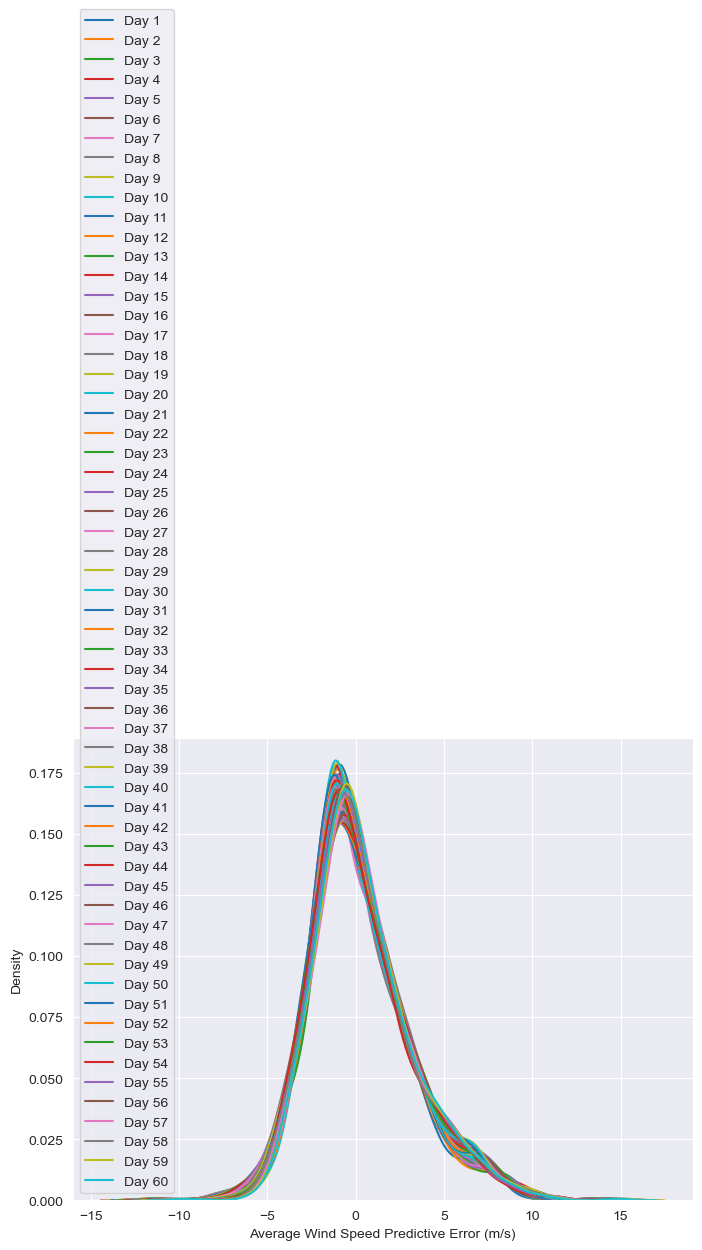

In [446]:
# Plot error density per day ahead of prediction
plot_error_density(RapViento_mean_error,feature_title[target_index],features[target_index],feature_unit[target_index],n_ahead,save=True) # save = True to save .svg

# Export Residuals

In [447]:
residuals = pd.concat([Temp_mean_error,
                       Temp_min_error,
                       Temp_max_error,
                       PresBarometr_mean_error,
                       RadSolar_mean_error,
                       RadSolar_max_error,
                       RapViento_mean_error
                       ], axis=1)
residuals.to_csv(f'results/N={n_ahead}/LSTM_Residuals_N={n_ahead}.csv', index=False)